
Processando PETR4.SA...
  Janela_1: Saldo=14161.86, Estratégia='Previsões Originais'
  Janela_2: Saldo=14762.20, Estratégia='Previsões Originais'
  Janela_3: Saldo=13154.79, Estratégia='Previsões Originais'
  Janela_4: Saldo=11852.42, Estratégia='Previsões Originais'

Processando BEEF3.SA...
  Janela_1: Saldo=8857.54, Estratégia='Previsões Originais'
  Janela_2: Saldo=8714.41, Estratégia='Previsões Originais'
  Janela_3: Saldo=7862.68, Estratégia='Previsões Originais'
  Janela_4: Saldo=10031.50, Estratégia='Previsões Originais'

Processando BRFS3.SA...
  Janela_1: Saldo=16471.98, Estratégia='Previsões Originais'
  Janela_2: Saldo=21584.61, Estratégia='Previsões Originais'
  Janela_3: Saldo=11733.34, Estratégia='Previsões Originais'
  Janela_4: Saldo=16971.76, Estratégia='Previsões Originais'

Processando VALE3.SA...
  Janela_1: Saldo=8887.88, Estratégia='Previsões Originais'
  Janela_2: Saldo=8891.08, Estratégia='Previsões Originais'
  Janela_3: Saldo=9811.01, Estratégia='Previsões Or

C:\Users\leona\AppData\Local\Temp\ipykernel_13464\3354765542.py:398: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=[trans_razoaveis_patch, trans_nao_razoaveis_patch, sem_trans_patch, prev_neg_patch, bars[0]], # Adiciona a linha do saldo inicial à legenda


Gráfico final (ajustado) salvo em: c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroResultados\resultado_trading_grafico_ajustado.png


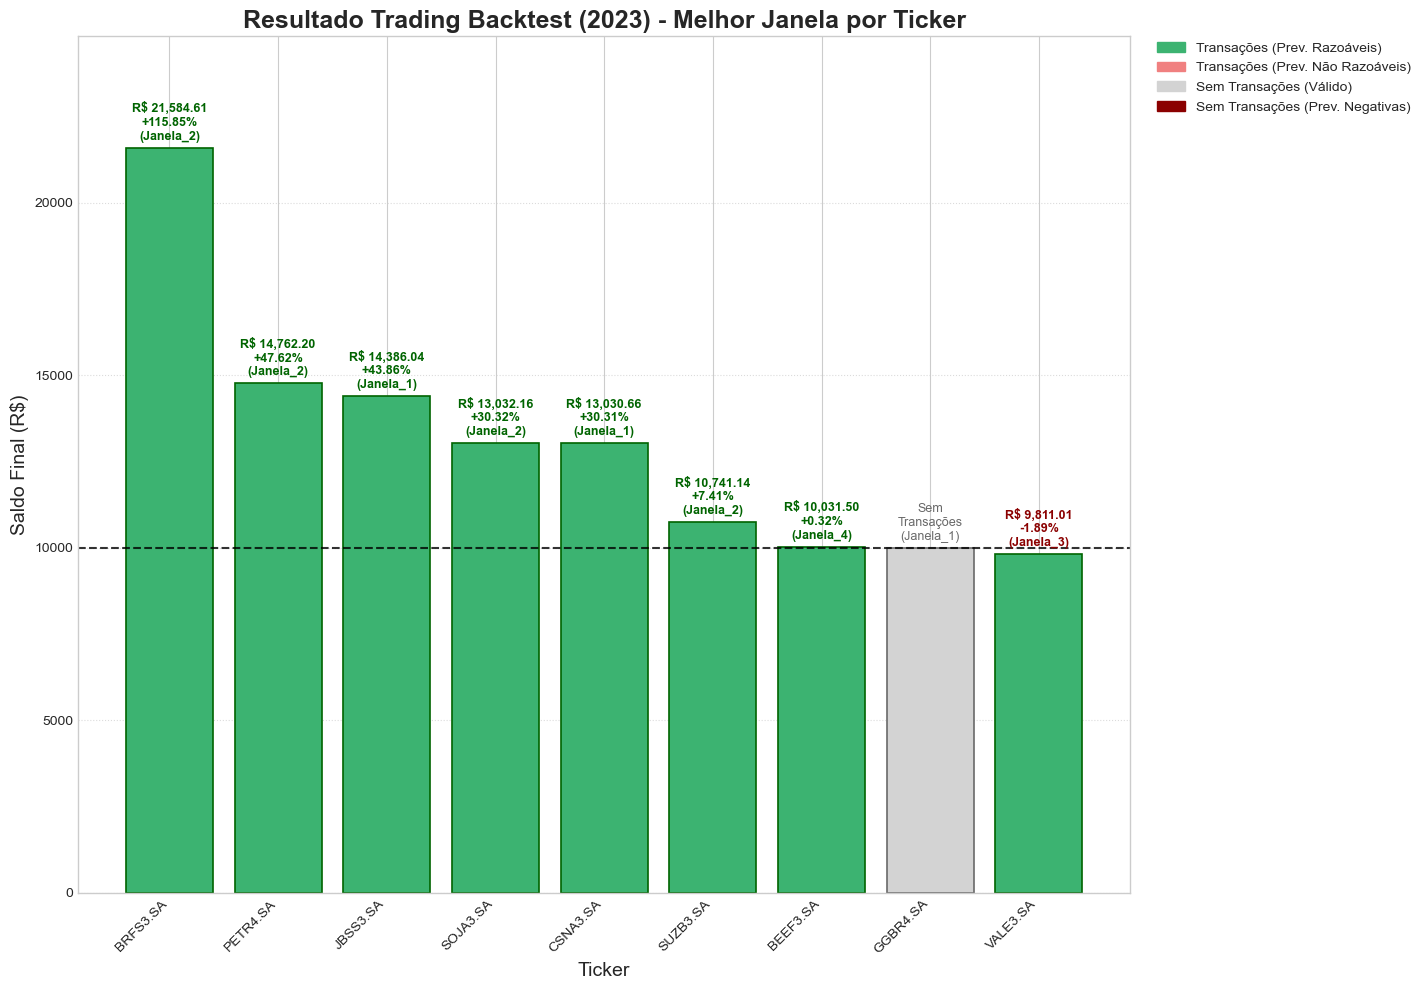


--- Execução Concluída ---


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Importar mpatches

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\Macro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes")
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["PETR4.SA", "BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR4.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# Estratégia "All-In" usando apenas previsões originais
def estrategia_all_in(dados_brutos, saldo_inicial):
    # Converter colunas para valores numéricos sem substituir as previsões
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')

    # Verificar se as previsões estão dentro de um intervalo razoável, apenas para diagnóstico
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None

    # Imprimir informações sobre as previsões (PARA DEBUG)
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty and 'Data' in dados_brutos.columns else "Unknown"
    # print(f"\n--- Debug Info for {identifier} ---") # Comentado para reduzir output
    # print(f"Min Previsto: {min_previsto}, Max Previsto: {max_previsto}, Média Previsto: {media_previsoes}")
    # print(f"Tipo Min Previsto: {type(min_previsto)}")

    # VERIFICAR SE A PREVISÃO MÍNIMA É EXTREMAMENTE NEGATIVA
    is_extremely_negative = False
    if min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_extremely_negative = True
        print(f"!!! DEBUG: Previsão mínima ({min_previsto}) é < -1000 para {identifier}. Marcado para bloquear transações. !!!")

    # Se marcado como extremamente negativo, retornar imediatamente
    if is_extremely_negative:
        # print(f"Previsões negativas extremas detectadas (Min={min_previsto}). Não realizando transações.") # Comentado
        diagnostico = {
            'Previsões Razoáveis': False,
            'Estratégia Usada': 'Sem transações - Previsões Negativas',
            'Total de Transações': 0,
            'Retorno (%)': 0.0,
            'Min Previsto': min_previsto,
            'Max Previsto': max_previsto,
            'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico # Retorna lista VAZIA de transações
    # else: # Comentado para reduzir output
         # print(f"Debug: Previsão mínima ({min_previsto}) não é < -1000 ou é None/Inválida. Prosseguindo com a estratégia...")

    # Prosseguir com a estratégia (somente se não for extremamente negativo)
    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = [] # Começa vazia

    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data']
        preco_real = dados.iloc[i]['Preço Real']
        if pd.isna(preco_real) or preco_real <= 0: continue
        preco_previsto = dados.iloc[i + 1]['Preço Previsto']
        if pd.isna(preco_previsto): continue

        if quantidade_acoes == 0 and preco_previsto > preco_real:
            quantidade_acoes = saldo / preco_real
            valor_transacao = saldo
            saldo = 0
            transacoes.append({'Data': data_atual, 'Acao': 'Compra', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        elif quantidade_acoes > 0 and preco_previsto < preco_real and i < len(dados) - 2: # Evita vender no penúltimo dia baseado na última previsão
            valor_transacao = quantidade_acoes * preco_real
            saldo = valor_transacao
            transacoes.append({'Data': data_atual, 'Acao': 'Venda', 'Preco': preco_real, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
            quantidade_acoes = 0

    # Venda final no último dia se ainda houver ações
    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            valor_transacao = quantidade_acoes * ultimo_preco
            saldo = valor_transacao
            transacoes.append({'Data': dados.iloc[-1]['Data'], 'Acao': 'Venda Final', 'Preco': ultimo_preco, 'Quantidade': quantidade_acoes, 'Valor Total': valor_transacao, 'Saldo Restante': saldo})
        else:
             # Se o último preço for inválido, considera perda total do valor investido
             print(f"AVISO: Último preço real inválido para {identifier}. Saldo zerado na venda final.")
             saldo = 0 # Ou outra lógica de tratamento, como usar o penúltimo preço

    # Diagnóstico Final
    previsoes_razoaveis = not is_extremely_negative # Simplificado: Razoável se não for extremamente negativo
    estrategia_usada_diag = 'Previsões Originais' if len(transacoes) > 0 else 'Sem transações'
    if is_extremely_negative: # Garante que a flag negativa sobrescreva
        estrategia_usada_diag = 'Sem transações - Previsões Negativas'

    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada_diag,
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100 if saldo_inicial != 0 else 0,
        'Min Previsto': min_previsto,
        'Max Previsto': max_previsto,
        'Média Previsto': media_previsoes
    }
    # print(f"Diagnóstico da estratégia para {identifier}: {diagnostico}") # Comentado

    return saldo, transacoes, diagnostico

# Processar os resultados de previsões para todos os tickers, comparando as janelas
def processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial):
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}

    for ticker in tickers:
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        print(f"\nProcessando {ticker}...")
        for janela in janelas:
            previsoes_file = os.path.join(input_dir, ticker, janela, f"{ticker}_{janela}_previsoes_teste_final.csv")
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    # Adiciona identificador único para a função de estratégia
                    dados['Data'] = dados['Data'] + f"_{ticker}_{janela}" 
                    saldo_final, transacoes, diagnostico = estrategia_all_in(dados, saldo_inicial)
                    todas_transacoes[ticker][janela] = transacoes
                    todos_diagnosticos[ticker][janela] = diagnostico
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno {janela} (%)"] = diagnostico['Retorno (%)']
                    ticker_resultados[f"Estratégia {janela}"] = diagnostico['Estratégia Usada']
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = diagnostico['Previsões Razoáveis']
                    print(f"  {janela}: Saldo={saldo_final:.2f}, Estratégia='{diagnostico['Estratégia Usada']}'")
                except Exception as e:
                    print(f"  Erro ao processar {ticker} - {janela}: {str(e)}")
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                    ticker_resultados[f"Estratégia {janela}"] = "Erro"
                    ticker_resultados[f"Previsões Razoáveis {janela}"] = False
            else:
                print(f"  Arquivo não encontrado: {previsoes_file}")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno {janela} (%)"] = 0.0
                ticker_resultados[f"Estratégia {janela}"] = "Arquivo não encontrado"
                ticker_resultados[f"Previsões Razoáveis {janela}"] = False
        resultados.append(ticker_resultados)
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL ---
saldo_inicial = 10000
df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial)

# Salvar resultados comparativos
resultados_filepath = os.path.join(output_dir, "resultados_comparativos_janelas.csv")
df_resultados.to_csv(resultados_filepath, index=False)
print(f"\nResultados comparativos salvos em: {resultados_filepath}")

# Salvar diagnósticos
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos.get(ticker, {}):
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker; diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)
if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_estrategias.csv")
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"Diagnósticos de estratégias salvos em: {diagnosticos_filepath}")

# Salvar TODAS as transações
print("\n--- Iniciando salvamento de TODAS as transações por janela ---")
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    for janela in janelas:
        if janela in todas_transacoes.get(ticker, {}):
            transacoes = todas_transacoes[ticker][janela]
            if transacoes: # Salva SOMENTE se a lista NÃO for vazia
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes.csv")
                df_transacoes.to_csv(transacoes_filepath, index=False)
                # print(f"    SALVANDO Transações para {ticker} - {janela}") # Comentado
            # else: # Comentado
                # print(f"    NÃO SALVANDO Transações para {ticker}, Janela {janela} (lista vazia)")
        # else: # Comentado
             # print(f"    AVISO: Não foram encontradas transações no dicionário para {ticker}, Janela {janela}")
print("--- Salvamento de TODAS as transações concluído ---")


# Identificar a MELHOR JANELA para cada ticker (LÓGICA AJUSTADA)
print("\n--- Identificando melhor janela para cada ticker (Lógica Ajustada) ---")
melhores_resultados_plot = []
for _, row in df_resultados.iterrows():
    ticker = row['Ticker']
    
    melhor_janela_final = None
    melhor_saldo_final = -np.inf
    melhor_estrategia_final = None
    tem_transacoes_final = False
    print_msg = "Nenhuma janela válida encontrada" # Default message

    # 1. Buscar a melhor janela COM transações ('Previsões Originais')
    melhor_janela_com_trans = None
    melhor_saldo_com_trans = -np.inf
    for janela in janelas:
        estrategia = row.get(f"Estratégia {janela}")
        saldo = row.get(f"Saldo Final {janela}")
        if estrategia == 'Previsões Originais' and saldo is not None and pd.notna(saldo):
            if saldo > melhor_saldo_com_trans:
                melhor_saldo_com_trans = saldo
                melhor_janela_com_trans = janela

    # 2. Se encontrou janela COM transações, usar essa
    if melhor_janela_com_trans is not None:
        melhor_janela_final = melhor_janela_com_trans
        melhor_saldo_final = melhor_saldo_com_trans
        melhor_estrategia_final = 'Previsões Originais'
        tem_transacoes_final = True
        print_msg = "Melhor janela válida com transações"
    else:
        # 3. Se NÃO encontrou com transações, buscar a melhor janela SEM transações (mas válida)
        melhor_janela_sem_trans = None
        # Para 'Sem transações', o saldo é sempre o inicial, então apenas pegamos a primeira válida encontrada
        for janela in janelas:
            estrategia = row.get(f"Estratégia {janela}")
            # Aceita 'Sem transações', exclui as inválidas
            if estrategia == 'Sem transações': 
                 if melhor_janela_sem_trans is None: # Pega a primeira janela 'Sem transações'
                     melhor_janela_sem_trans = janela
                     break # Já achamos uma, não precisamos de outras 'Sem transações'
        
        # 4. Se encontrou janela 'Sem transações', usar essa
        if melhor_janela_sem_trans is not None:
             melhor_janela_final = melhor_janela_sem_trans
             melhor_saldo_final = saldo_inicial # Saldo é o inicial
             melhor_estrategia_final = 'Sem transações'
             tem_transacoes_final = False
             print_msg = "Janela selecionada (sem transações)"
        else:
             # 5. Fallback: Se só sobraram erros, previsões negativas ou não encontrados
             # Tenta pegar a primeira janela que não seja explicitamente negativa ou erro
             for janela in janelas:
                 estrategia = row.get(f"Estratégia {janela}")
                 if estrategia not in ['Sem transações - Previsões Negativas', 'Erro', 'Arquivo não encontrado']:
                     melhor_janela_final = janela
                     melhor_saldo_final = saldo_inicial
                     melhor_estrategia_final = estrategia # Pode ser None se a coluna não existir
                     tem_transacoes_final = False
                     print_msg = "Janela selecionada (fallback, sem transações)"
                     break
             # 6. Fallback extremo: Se TUDO falhou (improvável)
             if melhor_janela_final is None:
                 melhor_janela_final = janelas[0]
                 melhor_saldo_final = saldo_inicial
                 melhor_estrategia_final = row.get(f"Estratégia {janelas[0]}", "Status Desconhecido")
                 tem_transacoes_final = False
                 print_msg = "Janela selecionada (fallback extremo)"

    # Adicionar aos resultados para plotagem
    previsoes_razoaveis = row.get(f"Previsões Razoáveis {melhor_janela_final}", False)
    # Garante que se a estratégia for negativa, as previsões sejam marcadas como não razoáveis
    if melhor_estrategia_final == 'Sem transações - Previsões Negativas':
        previsoes_razoaveis = False
        
    melhores_resultados_plot.append({
        'Ticker': ticker, 
        'Melhor Janela': melhor_janela_final, 
        'Saldo Final': melhor_saldo_final,
        # Pega o retorno da janela selecionada, ou 0.0 se não houver
        'Retorno (%)': row.get(f"Retorno {melhor_janela_final} (%)", 0.0), 
        'Estratégia Usada': melhor_estrategia_final if melhor_estrategia_final is not None else "N/A",
        'Previsões Razoáveis': previsoes_razoaveis,
        'Tem Transações': tem_transacoes_final # Usa a flag definida na lógica acima
    })
    print(f"    {print_msg} para {ticker}: {melhor_janela_final} (Saldo: {melhor_saldo_final:.2f}, Estratégia: {melhor_estrategia_final})")

# Processar e salvar MELHORES resultados
df_melhores_plot = pd.DataFrame(melhores_resultados_plot).sort_values(by='Retorno (%)', ascending=False)

melhores_filepath = os.path.join(output_dir, "melhores_resultados.csv")
df_melhores_plot.to_csv(melhores_filepath, index=False)
print(f"\nMelhores resultados (lógica ajustada) salvos em: {melhores_filepath}")

# Salvar transações SOMENTE da MELHOR JANELA (se teve transações)
print("\n--- Iniciando salvamento das transações da MELHOR janela (se houver) ---")
todas_melhores_transacoes_list = [] 
for idx, row in df_melhores_plot.iterrows():
    ticker = row['Ticker']
    melhor_janela = row['Melhor Janela']
    
    # Salva apenas se 'Tem Transações' for True (ou seja, estratégia foi 'Previsões Originais')
    if not row['Tem Transações']: 
        # print(f"    Sem transações para {ticker} na janela {melhor_janela}, não salvando arquivo.") # Comentado
        continue

    if ticker in todas_transacoes and melhor_janela in todas_transacoes.get(ticker, {}):
        transacoes_melhor = todas_transacoes[ticker][melhor_janela]
        if transacoes_melhor: 
            # print(f"    SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela}") # Comentado
            df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
            melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_MELHOR_JANELA_{melhor_janela}_transacoes.csv")
            df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)
            # print(f"        Salvo em: {melhor_transacoes_filepath}") # Comentado

            # Adicionar ao consolidado
            for transacao in transacoes_melhor:
                transacao_info = {'Ticker': ticker, 'Janela': melhor_janela, 'Estratégia': row['Estratégia Usada'], 'Previsões Razoáveis': row['Previsões Razoáveis'], **transacao}
                todas_melhores_transacoes_list.append(transacao_info)
        # else: # Comentado
             # print(f"    NÃO SALVANDO Melhor Transação para {ticker}, Janela {melhor_janela} (lista vazia)")
    # else: # Comentado
        # print(f"    AVISO: Não foram encontradas transações no dicionário para a melhor janela de {ticker} ({melhor_janela})")
print("--- Salvamento das MELHORES transações concluído ---")

# Salvar consolidado se houver dados
if todas_melhores_transacoes_list:
    df_todas_melhores = pd.DataFrame(todas_melhores_transacoes_list)
    consolidado_filepath = os.path.join(output_dir, "todas_melhores_transacoes_consolidado.csv")
    df_todas_melhores.to_csv(consolidado_filepath, index=False)
    print(f"\nTodas as transações das melhores janelas consolidadas em: {consolidado_filepath}")

# Gerar gráfico final (incluindo todos os tickers)
print("\n--- Gerando gráfico final (Lógica Ajustada) ---")
plt.style.use('seaborn-v0_8-whitegrid') # Usar um estilo diferente
plt.figure(figsize=(16, 10)) # Aumentar tamanho

# Cores baseadas na lógica ajustada
colors = []
edge_colors = []
for idx, row in df_melhores_plot.iterrows():
    if row['Estratégia Usada'] == 'Sem transações - Previsões Negativas':
         colors.append('darkred') # Vermelho escuro para previsões negativas
         edge_colors.append('black')
    elif not row['Tem Transações']:
        colors.append('lightgray')  # Cinza para tickers sem transações (mas válidos)
        edge_colors.append('dimgray')
    elif row['Previsões Razoáveis']:
        colors.append('mediumseagreen') # Verde para previsões razoáveis com transações
        edge_colors.append('darkgreen')
    else: # Transações com previsões não razoáveis (mas não negativas extremas)
        colors.append('lightcoral') # Coral claro
        edge_colors.append('darkred')


bars = plt.bar(df_melhores_plot['Ticker'], df_melhores_plot['Saldo Final'], 
               color=colors, edgecolor=edge_colors, linewidth=1.2) # Adiciona borda
plt.axhline(y=saldo_inicial, color='black', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com informações
for i, bar in enumerate(bars):
    row = df_melhores_plot.iloc[i]
    saldo = row['Saldo Final']
    retorno = row['Retorno (%)']
    janela = row['Melhor Janela']
    estrategia = row['Estratégia Usada']
    
    y_pos = bar.get_height() + 150 # Posição base do texto
    
    if estrategia == 'Sem transações - Previsões Negativas':
         plt.text(i, y_pos, "Previsões\nNegativas", ha='center', va='bottom', color='darkred', fontsize=9, fontweight='bold')
    elif not row['Tem Transações']:
        plt.text(i, y_pos, f"Sem\nTransações\n({janela})", ha='center', va='bottom', color='dimgray', fontsize=9)
    else: # Teve transações
        text_color = 'darkgreen' if retorno >= 0 else 'darkred'
        retorno_text = f"+{retorno:.2f}%" if retorno >= 0 else f"{retorno:.2f}%"
        plt.text(i, y_pos,
                 f"R$ {saldo:,.2f}\n{retorno_text}\n({janela})",
                 ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)

plt.title('Resultado Trading Backtest (2023) - Melhor Janela por Ticker', fontsize=18, fontweight='bold')
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Saldo Final (R$)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.ylim(bottom=0, top=df_melhores_plot['Saldo Final'].max() * 1.15) # Ajusta limite superior

# Legenda Atualizada
trans_razoaveis_patch = mpatches.Patch(color='mediumseagreen', label='Transações (Prev. Razoáveis)')
trans_nao_razoaveis_patch = mpatches.Patch(color='lightcoral', label='Transações (Prev. Não Razoáveis)')
sem_trans_patch = mpatches.Patch(color='lightgray', label='Sem Transações (Válido)')
prev_neg_patch = mpatches.Patch(color='darkred', label='Sem Transações (Prev. Negativas)')
# saldo_inicial_line = mpatches.Patch(color='black', linestyle='--', label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}') # Linha já tem label

plt.legend(handles=[trans_razoaveis_patch, trans_nao_razoaveis_patch, sem_trans_patch, prev_neg_patch, bars[0]], # Adiciona a linha do saldo inicial à legenda
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10) 
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajusta layout para caber a legenda

grafico_final_filepath = os.path.join(output_dir, "resultado_trading_grafico_ajustado.png")
plt.savefig(grafico_final_filepath, dpi=300, bbox_inches='tight')
print(f"Gráfico final (ajustado) salvo em: {grafico_final_filepath}")
plt.show()

print("\n--- Execução Concluída ---")